# Experiment 2: Generate CIFAR-10 Images for Evaluation

This notebook generates large batches of CIFAR-10 images from the trained diffusion model for FID and classification evaluation.

**Purpose:**
- Generate 100 images per class at multiple guidance scales
- Save images to outputs/experiment_2/generated/{guidance_scale}/{class_name}/
- Prepare dataset for FID computation and classifier evaluation

**Configuration:**
- 10 CIFAR-10 classes
- 100 images per class
- Multiple guidance scales: [0, 2, 5, 10]
- Total: 4,000 images (1,000 per guidance scale)

**Prerequisites:**
- Complete training using `train1_t2i_cifar10_cfg.ipynb`

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_2_CONFIG,
    INFERENCE_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    CIFAR10_CLASSES,
    EXPERIMENT_2_GENERATED_DIR,
    get_cifar10_generated_images_dir,
    get_class_dir,
    ensure_experiment_2_dirs,
)

# Deep learning frameworks
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Image saving
from PIL import Image

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Generation configuration
GUIDANCE_SCALES = [0, 2, 5, 10]  # Guidance scales to evaluate
IMAGES_PER_CLASS = EXPERIMENT_2_CONFIG["images_per_class"]  # 100
BATCH_SIZE = 16  # Generate in batches for efficiency
NUM_INFERENCE_STEPS = INFERENCE_CONFIG["num_inference_steps"]

print(f"Generation configuration:")
print(f"  Classes: {len(CIFAR10_CLASSES)} ({CIFAR10_CLASSES})")
print(f"  Images per class: {IMAGES_PER_CLASS}")
print(f"  Guidance scales: {GUIDANCE_SCALES}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"  Total images: {len(GUIDANCE_SCALES) * len(CIFAR10_CLASSES) * IMAGES_PER_CLASS}")

Generation configuration:
  Classes: 10 (['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
  Images per class: 100
  Guidance scales: [0, 2, 5, 10]
  Batch size: 16
  Inference steps: 50
  Total images: 4000


In [4]:
# Create output directories
ensure_experiment_2_dirs()

for guidance_scale in GUIDANCE_SCALES:
    base_dir = get_cifar10_generated_images_dir(guidance_scale)
    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
        class_dir = get_class_dir(base_dir, class_idx)
        class_dir.mkdir(parents=True, exist_ok=True)

print(f"\nOutput directories created in: {EXPERIMENT_2_GENERATED_DIR}")


Output directories created in: /home/doshlom4/work/final_project/outputs/experiment_2/generated


## 2. Load Models

In [5]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


In [6]:
# Load trained UNet from latest checkpoint
from models.custom_unet_cifar10 import load_cifar10_unet_from_latest_checkpoint

unet, checkpoint = load_cifar10_unet_from_latest_checkpoint(device=device)
unet.eval()

print(f"✓ Loaded CIFAR-10 UNet model")
print(f"  Parameters: {unet.get_num_parameters():,}")

Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/cifar10_unet_checkpoint_epoch_50.pt
Loaded model from epoch 50
✓ Loaded CIFAR-10 UNet model
  Parameters: 35,499,523


In [7]:
# Load CLIP text encoder and tokenizer
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME).to(device)
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)

text_encoder.eval()

print(f"✓ Loaded CLIP text encoder: {CLIP_MODEL_NAME}")

✓ Loaded CLIP text encoder: openai/clip-vit-base-patch32


In [8]:
# Create noise scheduler for inference
scheduler = DDPMScheduler(
    beta_schedule=INFERENCE_CONFIG["beta_schedule"],
    num_train_timesteps=INFERENCE_CONFIG["num_train_timesteps"]
)

print(f"✓ Created DDPM scheduler")

✓ Created DDPM scheduler


## 3. Generation Functions

In [9]:
@torch.no_grad()
def generate_batch(
    prompt: str,
    guidance_scale: float,
    batch_size: int,
) -> torch.Tensor:
    """
    Generate a batch of CIFAR-10 images using classifier-free guidance.
    
    Args:
        prompt: Text prompt for generation
        guidance_scale: CFG scale
        batch_size: Number of images to generate
        
    Returns:
        Tensor of shape (batch_size, 3, 32, 32) in [0, 255] uint8 range
    """
    # Encode text prompt
    text_input = tokenizer(
        [prompt] * batch_size,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize random noise
    latents = torch.randn((batch_size, 3, 32, 32), device=device)
    
    # Setup scheduler
    scheduler.set_timesteps(NUM_INFERENCE_STEPS)
    
    # Denoising loop
    for t in scheduler.timesteps:
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Denormalize from [-1, 1] to [0, 1] then to [0, 255]
    images = (latents / 2 + 0.5).clamp(0, 1)
    images = (images * 255).round().byte()
    
    return images.cpu()

print("Generation function defined")

Generation function defined


In [10]:
def save_images_to_folder(images: torch.Tensor, output_dir: Path, start_index: int = 0):
    """
    Save a batch of images to a folder.
    
    Args:
        images: Tensor of shape (N, 3, 32, 32) in uint8 format
        output_dir: Directory to save images
        start_index: Starting index for image naming
    """
    for i, img_tensor in enumerate(images):
        # Convert to PIL image
        img = img_tensor.permute(1, 2, 0).numpy()
        img_pil = Image.fromarray(img)
        
        # Save
        img_path = output_dir / f"{start_index + i:04d}.png"
        img_pil.save(img_path)

print("Image saving function defined")

Image saving function defined


## 4. Generate Images

In [11]:
def generate_for_guidance_scale(guidance_scale: float):
    """
    Generate images for all classes at a given guidance scale.
    """
    print(f"\n{'='*60}")
    print(f"Generating images with guidance scale w={guidance_scale}")
    print(f"{'='*60}")
    
    output_dir = get_cifar10_generated_images_dir(guidance_scale)
    
    for class_idx, class_name in enumerate(tqdm(CIFAR10_CLASSES, desc=f"w={guidance_scale}")):
        prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
        class_dir = get_class_dir(output_dir, class_idx)
        
        # Generate in batches
        num_generated = 0
        while num_generated < IMAGES_PER_CLASS:
            batch_size = min(BATCH_SIZE, IMAGES_PER_CLASS - num_generated)
            
            images = generate_batch(prompt, guidance_scale, batch_size)
            save_images_to_folder(images, class_dir, start_index=num_generated)
            
            num_generated += batch_size
    
    # Count generated images
    total = sum(
        len(list((output_dir / f"class_{i}_{class_name}").glob("*.png")))
        for i, class_name in enumerate(CIFAR10_CLASSES)
    )
    print(f"✓ Generated {total} images for w={guidance_scale}")

print("Generation function defined")

Generation function defined


In [12]:
# Main generation loop
start_time = datetime.now()

print(f"Starting CIFAR-10 image generation")
print(f"Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total images to generate: {len(GUIDANCE_SCALES) * len(CIFAR10_CLASSES) * IMAGES_PER_CLASS}")

for guidance_scale in GUIDANCE_SCALES:
    generate_for_guidance_scale(guidance_scale)

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

print(f"\n{'='*60}")
print(f"Generation Complete!")
print(f"{'='*60}")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Output directory: {EXPERIMENT_2_GENERATED_DIR}")

Starting CIFAR-10 image generation
Time: 2026-01-25 15:14:36
Total images to generate: 4000

Generating images with guidance scale w=0


w=0: 100%|██████████| 10/10 [01:30<00:00,  9.00s/it]


✓ Generated 1000 images for w=0

Generating images with guidance scale w=2


w=2: 100%|██████████| 10/10 [01:30<00:00,  9.02s/it]


✓ Generated 1000 images for w=2

Generating images with guidance scale w=5


w=5: 100%|██████████| 10/10 [01:29<00:00,  8.96s/it]


✓ Generated 1000 images for w=5

Generating images with guidance scale w=10


w=10: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]

✓ Generated 1000 images for w=10

Generation Complete!
Total time: 6.0 minutes
Output directory: /home/doshlom4/work/final_project/outputs/experiment_2/generated


## 5. Verify Generated Images

In [17]:
# Count all generated images
print("Generated image counts:")
print(f"{'='*60}")

total_all = 0
for guidance_scale in GUIDANCE_SCALES:
    output_dir = get_cifar10_generated_images_dir(guidance_scale)
    
    total_gs = 0
    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
        class_dir = get_class_dir(output_dir, class_idx)
        count = len(list(class_dir.glob("*.png"))) if class_dir.exists() else 0
        total_gs += count
    
    total_all += total_gs
    print(f"  w={guidance_scale}: {total_gs} images")

print(f"{'='*60}")
print(f"  Total: {total_all} images")

Generated image counts:
  w=0: 1000 images
  w=2: 1000 images
  w=5: 1000 images
  w=10: 1000 images
  Total: 4000 images


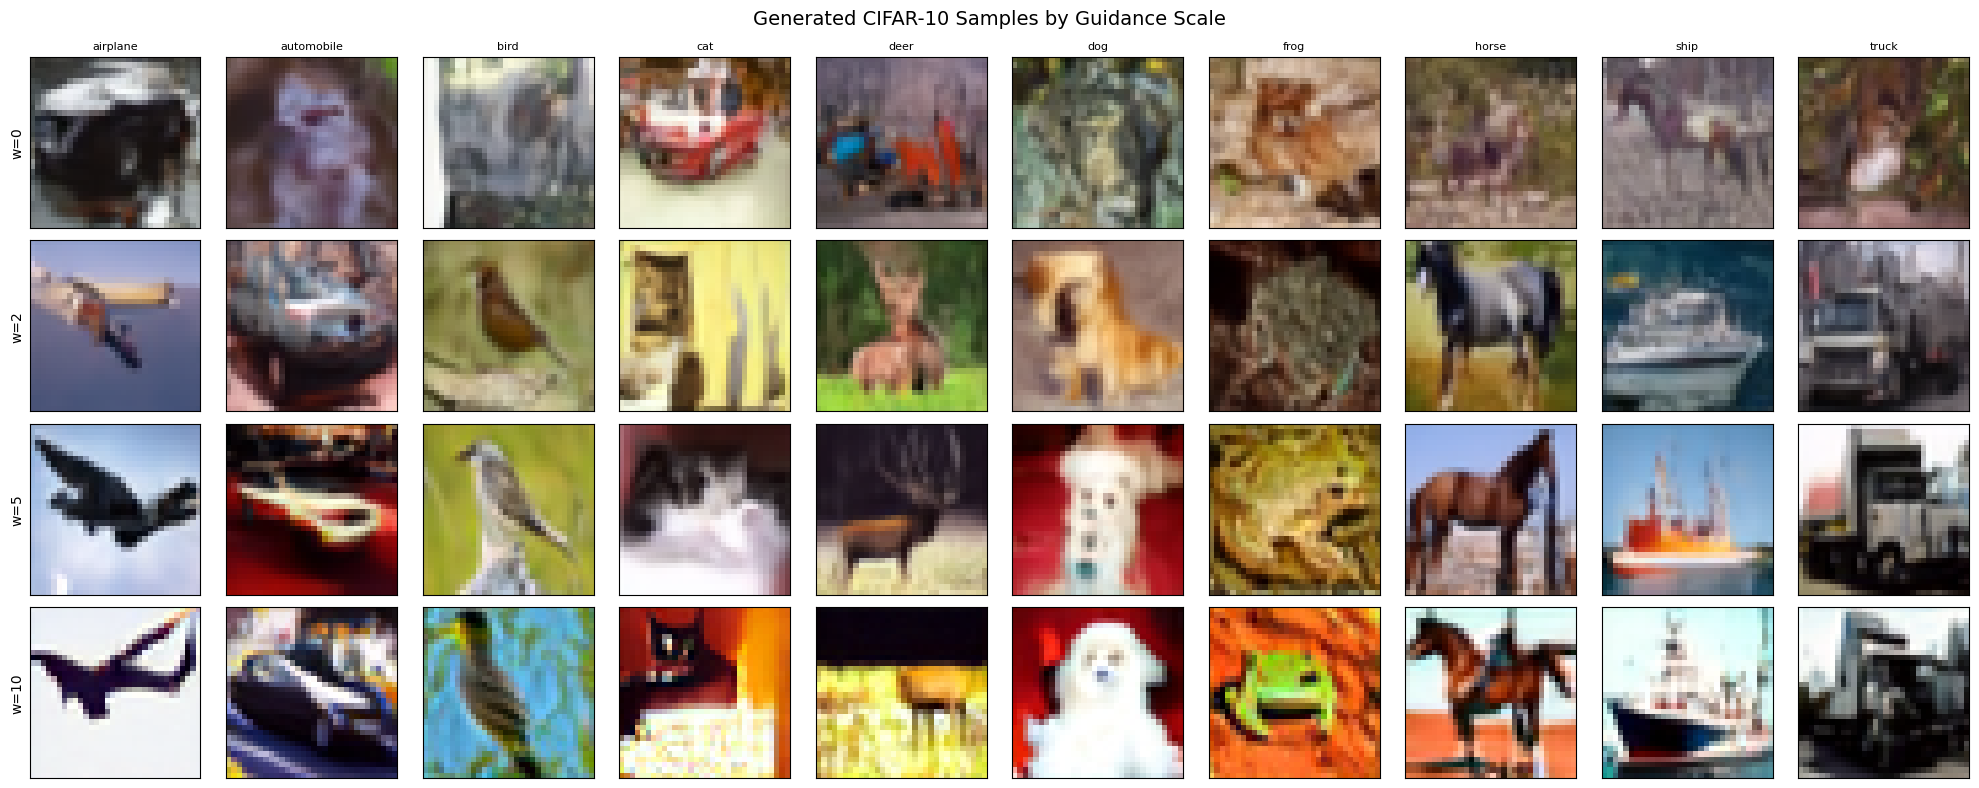

In [18]:
# Visualize samples from each guidance scale
fig, axes = plt.subplots(len(GUIDANCE_SCALES), len(CIFAR10_CLASSES), figsize=(20, 8))

for i, guidance_scale in enumerate(GUIDANCE_SCALES):
    output_dir = get_cifar10_generated_images_dir(guidance_scale)
    for j, class_name in enumerate(CIFAR10_CLASSES):
        class_dir = get_class_dir(output_dir, j)
        
        # Load first image
        img_path = class_dir / "0000.png"
        if img_path.exists():
            img = Image.open(img_path)
            axes[i, j].imshow(img)
        
        if i == 0:
            axes[i, j].set_title(class_name, fontsize=8)
        if j == 0:
            axes[i, j].set_ylabel(f"w={guidance_scale}", fontsize=10)
        
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.suptitle('Generated CIFAR-10 Samples by Guidance Scale', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Directory Structure Summary

In [15]:
# Print directory structure
print(f"\nOutput directory structure:")
print(f"{EXPERIMENT_2_GENERATED_DIR}")

for guidance_scale in GUIDANCE_SCALES:
    output_dir = get_cifar10_generated_images_dir(guidance_scale)
    gs_name = f"w{guidance_scale}" if isinstance(guidance_scale, int) else f"w{guidance_scale:.1f}"
    print(f"├── {gs_name}/")
    
    for i, class_name in enumerate(CIFAR10_CLASSES):
        class_dir = get_class_dir(output_dir, i)
        count = len(list(class_dir.glob("*.png"))) if class_dir.exists() else 0
        prefix = "└──" if i == len(CIFAR10_CLASSES) - 1 else "├──"
        print(f"│   {prefix} class_{i}_{class_name}/ ({count} images)")
    print("│")


Output directory structure:
/home/doshlom4/work/final_project/outputs/experiment_2/generated
├── w0/
│   ├── class_0_airplane/ (100 images)
│   ├── class_1_automobile/ (100 images)
│   ├── class_2_bird/ (100 images)
│   ├── class_3_cat/ (100 images)
│   ├── class_4_deer/ (100 images)
│   ├── class_5_dog/ (100 images)
│   ├── class_6_frog/ (100 images)
│   ├── class_7_horse/ (100 images)
│   ├── class_8_ship/ (100 images)
│   └── class_9_truck/ (100 images)
│
├── w2/
│   ├── class_0_airplane/ (100 images)
│   ├── class_1_automobile/ (100 images)
│   ├── class_2_bird/ (100 images)
│   ├── class_3_cat/ (100 images)
│   ├── class_4_deer/ (100 images)
│   ├── class_5_dog/ (100 images)
│   ├── class_6_frog/ (100 images)
│   ├── class_7_horse/ (100 images)
│   ├── class_8_ship/ (100 images)
│   └── class_9_truck/ (100 images)
│
├── w5/
│   ├── class_0_airplane/ (100 images)
│   ├── class_1_automobile/ (100 images)
│   ├── class_2_bird/ (100 images)
│   ├── class_3_cat/ (100 images)
│   ├── c

## Summary

This notebook generated CIFAR-10 images for evaluation:

**Generated:**
- 100 images × 10 classes × 4 guidance scales = 4,000 total images
- Saved as PNG files in `outputs/experiment_2/generated/`

**Directory structure:**
- `outputs/experiment_2/generated/w{scale}/{class_name}/0000.png, 0001.png, ...`

**Next steps:**
1. Run `metrics1_evaluate_cifar10.ipynb` to compute:
   - FID score (image quality)
   - Classifier accuracy (prompt adherence)